Feature engineering

### Приют домашних животных / конструирование признаков  для для модели классификации 

In [392]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import re

Представлен датасет центра приюта животных

Задача: выявление признаков датасета, обеспечивающих ниболее точное предсказание меток 'Adoption' и 'Transfer' (столбец “outcome_type”), тестирование и оптимизация модели

В рамках задачи необходимо
1. Проверить наличие/обработать пропуски
2. Проверить взаимосвязи между признаками
3. Попробовать создать новые признаки / в том числе из состава текст столбцов
4. Удалить лишние признаки
5. Попробовать использование метода PCA (Метод главных компонент). 

In [428]:
data = pd.read_csv('aac_shelter_outcomes.csv', delimiter = ',')
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [429]:
data.isna().sum()[data.isna().sum()>0]

age_upon_outcome        8
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

### 1.  outcome_type  и outcome_subtype - результирующие признаки

In [430]:
data[data.outcome_type.isna()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
10753,1 year,A671017,Other,Fox Mix,Brown/Black,2013-01-17T00:00:00,2014-01-20T08:27:00,2014-01-20T08:27:00,NaN,NaN,NaN,Unknown
13270,0 years,A674209,Other,Bat Mix,Brown,2014-03-09T00:00:00,2014-03-09T18:15:00,2014-03-09T18:15:00,NaN,NaN,NaN,Unknown
13302,4 weeks,A679066,Other,Rabbit Sh,Brown,2014-04-16T00:00:00,2014-05-16T00:00:00,2014-05-16T00:00:00,NaN,NaN,NaN,Unknown
16951,1 year,A686025,Other,Bat Mix,Brown,2013-08-15T00:00:00,2014-08-16T08:35:00,2014-08-16T08:35:00,NaN,NaN,NaN,Unknown
29214,1 year,A744013,Other,Bat Mix,Black,2016-02-21T00:00:00,2017-02-24T09:00:00,2017-02-24T09:00:00,NaN,NaN,NaN,Unknown
64626,1 month,A755711,Cat,Domestic Shorthair Mix,Black,2017-07-06T00:00:00,2017-08-21T10:09:00,2017-08-21T10:09:00,*Dewey,NaN,NaN,Intact Male
68246,NaN,A737705,Dog,Labrador Retriever Mix,Black/White,2013-11-02T00:00:00,2016-11-19T16:35:00,2016-11-19T16:35:00,*Heddy,NaN,NaN,NaN
69847,1 month,A755715,Cat,Domestic Shorthair Mix,Black Smoke,2017-06-29T00:00:00,2017-08-21T10:09:00,2017-08-21T10:09:00,*Louie,NaN,NaN,Intact Female
72037,1 month,A755716,Cat,Domestic Shorthair Mix,Blue,2017-07-06T00:00:00,2017-08-21T10:09:00,2017-08-21T10:09:00,*Huey,NaN,NaN,Intact Female
76709,10 years,A718046,Dog,Chihuahua Longhair Mix,Cream,2005-12-20T00:00:00,2016-03-26T00:00:00,2016-03-26T00:00:00,Bailey,NaN,NaN,Neutered Male


По полю outcome_type - менее 0.01 % наблюдений, 5 видов  разных живтных, вряд ли удаление пропусков по признаку outcome_type исказит общую картину / удаляем 12 записей с отсутствующими значениями  outcome_type

In [431]:
data.dropna(subset = ['outcome_type'], inplace=True)
data.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [432]:
data.loc[data.outcome_type == 'Disposal', 'outcome_type'] = 'Outcome_type_other'
data.loc[data.outcome_type == 'Rto-Adopt','outcome_type'] = 'Outcome_type_other'
data.loc[data.outcome_type == 'Missing',  'outcome_type'] = 'Outcome_type_other'
data.loc[data.outcome_type == 'Relocate', 'outcome_type'] = 'Outcome_type_other'
data.loc[data.outcome_type == 'Other',    'outcome_type'] = 'Outcome_type_other'
data.outcome_type.value_counts()

Adoption              33112
Transfer              23499
Return to Owner       14354
Euthanasia             6080
Died                    680
Outcome_type_other      519
Name: outcome_type, dtype: int64

In [433]:
# преобразуем параметр с помощью one hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe_enc               = OneHotEncoder()
outcome_type_values   = ohe_enc.fit_transform(data[['outcome_type']]).toarray()
outcome_type_columns  = ohe_enc.categories_[0]
outcome_type_data     = pd.DataFrame(outcome_type_values, columns = outcome_type_columns)
outcome_type_data.head(1)

,Adoption,Died,Euthanasia,Outcome_type_other,Return to Owner,Transfer
0,0.0,0.0,0.0,0.0,0.0,1.0


In [434]:
# соединяем таблицы
data.reset_index(inplace=True)
data = pd.concat([data, outcome_type_data], axis=1)
data.head(1)

,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Adoption,Died,Euthanasia,Outcome_type_other,Return to Owner,Transfer
0,0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,0.0,0.0,0.0,0.0,0.0,1.0


Дальше смотрим, насколько второй результирующий признак - outcome_subtype- информативен, способен внести ясности, увидим  распределение результирующих признаков между собой, 

In [435]:
pt_     = pd.pivot_table(data, 
                         values     = ['animal_type'],  
                         index      = ['outcome_subtype'],
                         columns    = ['outcome_type'], 
                         aggfunc    = ['count'])
pt_

count                                              
                    animal_type                                              
outcome_type           Adoption   Died Euthanasia Outcome_type_other Transfer
outcome_subtype                                                              
Aggressive                  NaN    NaN      506.0                NaN      NaN
At Vet                      NaN   33.0       26.0                NaN      NaN
Barn                        1.0    NaN        NaN                NaN      2.0
Behavior                    NaN    NaN      142.0                NaN      NaN
Court/Investigation         NaN    NaN       18.0                NaN      NaN
Enroute                     NaN   45.0        NaN                NaN      NaN
Foster                   5558.0    NaN        NaN                NaN      NaN
In Foster                   NaN  164.0        NaN               18.0      NaN
In Kennel                   NaN  335.0        NaN                8.0      NaN
In Surgery                  NaN   16.0        NaN                NaN      NaN
Medical                     NaN    NaN      259.0                NaN      NaN
Offsite                   367.0    NaN        NaN                NaN      NaN
Partner                     NaN    NaN        NaN                NaN  19660.0
Possible Theft              NaN    NaN        NaN                9.0      NaN
Rabies Risk                 NaN    NaN     2417.0                NaN      NaN
SCRP                        NaN    NaN        NaN                NaN   3211.0
Snr                         NaN    NaN        NaN                NaN    626.0
Suffering                   NaN    NaN     2514.0                NaN      NaN
Underage                    NaN    NaN       28.0                NaN      NaN

Видим, что признак outcome_subtype (особенно в части разъяснения меток Adoption и Transfer) мало что дает /  признак outcome_subtype на удаление

### 2. Переменные времени: age_upon_outcome, date_of_birth, datetime, monthyear


Поля datetime и monthyear очень похожи, проверим соответствие значений:

In [436]:
data['date_of_birth']          = data['date_of_birth'].astype('datetime64[ns]') 
data['datetime']               = data['datetime'].astype('datetime64[ns]') 
data['monthyear']              = data['monthyear'].astype('datetime64[ns]') 

data['datetime-monthyear']     = data['datetime'] - data['monthyear']
data['datetime-monthyear'].value_counts()  #  всегда  = 0

# data['monthyear'] всегда = data['datetime']  # одно из полей очевидно избыточно | к удалению

0 days    78244
Name: datetime-monthyear, dtype: int64

In [437]:
data.dropna(subset = ['age_upon_outcome'], inplace=True)

In [438]:
data['age_estimate_year'] = ((data['datetime'] - data['date_of_birth']).dt.days/365.25).round(0)
data['birth_year']        = data['date_of_birth'].dt.year
data.head(1)

,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,...,sex_upon_outcome,Adoption,Died,Euthanasia,Outcome_type_other,Return to Owner,Transfer,datetime-monthyear,age_estimate_year,birth_year
0,0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22 16:04:00,NaN,...,Intact Male,0.0,0.0,0.0,0.0,0.0,1.0,0 days,0.0,2014


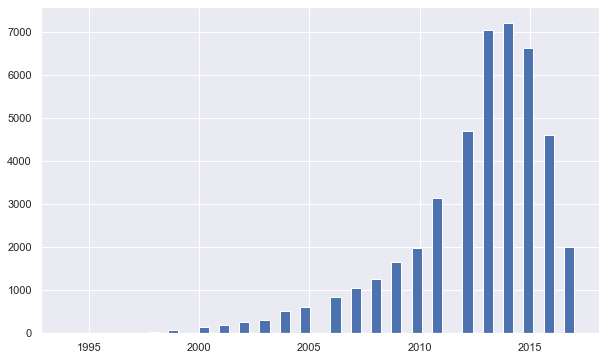

In [439]:
data[data['animal_type']=='Dog']['birth_year'].hist(figsize=(10,6), bins=50)

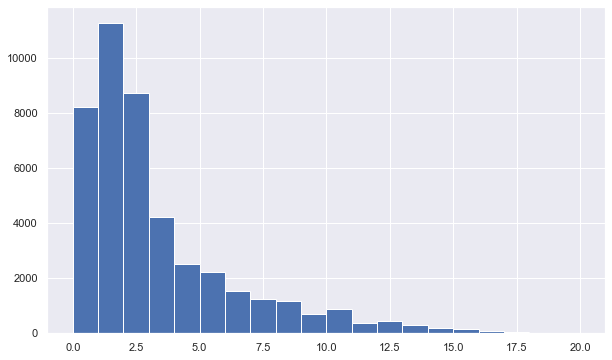

In [440]:
data[data['animal_type']=='Dog']['age_estimate_year'].hist(figsize=(10,6), bins=20)

###  3. Виды животных и породы

In [441]:
data['animal_type'].value_counts()

Dog          44235
Cat          29418
Other         4243
Bird           333
Livestock        9
Name: animal_type, dtype: int64

In [442]:
data[data['animal_type']=='Other'].breed.value_counts().head(10)

Bat Mix           1282
Bat                799
Raccoon Mix        465
Rabbit Sh Mix      291
Raccoon            230
Opossum Mix        176
Guinea Pig Mix     103
Opossum            102
Skunk Mix           79
Squirrel Mix        70
Name: breed, dtype: int64

Белки, опоссумы летучие мыши и попугаи - в топку. 
Ограничим исследование только традиционными домашними животными, в отношении которых понятна логика поведения человека вокруг животного и я обладаю хоть какими то компетенциями ...

In [443]:
data = data.loc[ data['animal_type'].isin(['Dog', 'Cat'])]
data['animal_type'].value_counts()

Dog    44235
Cat    29418
Name: animal_type, dtype: int64

Очистив датасет от всякой прочей живности мы подошли к бинарному признаку вида животного (или Кошка или Собака)

In [444]:
data.loc[data.animal_type.str.contains('Dog'), 'A_type']           = 1
data.loc[data.animal_type.str.contains('Cat'), 'A_type']           = 0                                 
data.A_type.value_counts()

1.0    44235
0.0    29418
Name: A_type, dtype: int64

Породы / breed

In [445]:
data.breed.value_counts().head()

Domestic Shorthair Mix      23331
Pit Bull Mix                 6133
Chihuahua Shorthair Mix      4733
Labrador Retriever Mix       4607
Domestic Medium Hair Mix     2323
Name: breed, dtype: int64

В составе поля Breed,  помимо собственно классификатора породы вижу дополнительные признаки :  Mix (чистота породы) и Hair (Мохнатость),  выделим признаки в отдельный столбец 

Далее выделим наиболее характерные породы животных и установим признак соответствия каждого животного наиболее характерным породам

In [446]:
data['breed'] = data.breed.str.lower()

data.loc[data.breed.str.contains('mix'),        'Breed_Mix']   = 1
data.loc[data.breed.str.contains('/'  ),        'Breed_Mix']   = 1                                 
data.loc[data.breed.str.contains('shorthair'),  'Hair_short']  = 1
data.loc[data.breed.str.contains('medium hair'), 'Hair_medium'] = 1
data.loc[data.breed.str.contains('longhair'),   'Hair_long']   = 1     


data.loc[data.breed.str.contains('bull'),      'Breed_bull']      = 1
data.loc[data.breed.str.contains('retriever'), 'Breed_retriever'] = 1
data.loc[data.breed.str.contains('shepherd'),  'Breed_shepherd']  = 1
data.loc[data.breed.str.contains('poodle'),    'Breed_poodle']    = 1
data.loc[data.breed.str.contains('collie'),    'Breed_collie']    = 1
data.loc[data.breed.str.contains('terrier'),   'Breed_terrier']   = 1
data.loc[data.breed.str.contains('husky'),     'Breed_husky']     = 1
data.loc[data.breed.str.contains('beagle'),    'Breed_beagle']    = 1
data.loc[data.breed.str.contains('dachshund'), 'Breed_dachshund'] = 1
data.loc[data.breed.str.contains('heeler'),    'Breed_heeler']    = 1
data.loc[data.breed.str.contains('australian cattle'
                                            ), 'Breed_heeler']    = 1
data.loc[data.breed.str.contains('chihuahua'), 'Breed_chihuahua'] = 1
data.loc[data.breed.str.contains('boxer'),     'Breed_boxer']     = 1
data.loc[data.breed.str.contains('catahoula'), 'Breed_catahoula'] = 1
data.loc[data.breed.str.contains('schnauzer'), 'Breed_schnauzer'] = 1
data.loc[data.breed.str.contains('domestic'),  'Breed_domestic']  = 1
data.loc[data.breed.str.contains('siamese'),   'Breed_siamese']   = 1

data = data.fillna(0)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.


Посмотрим, насколько отобранные признаки пород животных характеризуют общую выборку

In [447]:
d = data.iloc[:,[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]]
d['max_f']     = d.max(axis=1)
print('Отобранные признаки пород собак информативно покрывают базовую выборку на ',
      (100* d[d['max_f']>0].shape[0]/data.shape[0]), 'процентов')

Отобранные признаки пород собак информативно покрывают базовую выборку на  88.99162288026285 процентов


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Цвет

In [448]:
print('Итого цветов в датасете' , data.color.value_counts().shape[0])
print('Наиболее часто используются цвета:   \n' , data.color.value_counts().head(10))

Итого цветов в датасете 496
Наиболее часто используются цвета:   
 Black/White          7889
Black                6324
Brown Tabby          4445
White                2647
Brown/White          2402
Tan/White            2382
Brown Tabby/White    2338
Orange Tabby         2180
Blue/White           2068
White/Black          2005
Name: color, dtype: int64


Выделим наиболее часто встречающиеся цвета по выборке и определим степень соответствия окраса каждому из выбранных цветов

In [449]:
data.loc[data.color.str.contains('Black'), 'color_black'] = 1
data.loc[data.color.str.contains('White'), 'color_white'] = 1
data.loc[data.color.str.contains('Brown'), 'color_brown'] = 1
data.loc[data.color.str.contains('Orange'),'color_orange']= 1
data.loc[data.color.str.contains('Blue'),  'color_blue']  = 1
data.loc[data.color.str.contains('Tortie'),'color_brown'] = 1
data.loc[data.color.str.contains('Red'),   'color_red']   = 1
data.loc[data.color.str.contains('Yellow'),'color_yellow']= 1
data.loc[data.color.str.contains('Gray'),  'color_gray']  = 1
data.loc[data.color.str.contains('/'),     'color_mix']   = 1

In [450]:
# Итого имеем уже:

print('Black ', data.color_black.value_counts()[1], 'наблюдений (включая смешанные)')
print('White ', data.color_white.value_counts()[1], 'наблюдений (включая смешанные)')
print('Orange', data.color_orange.value_counts()[1], 'наблюдений (включая смешанные)')
print('Gray  ', data.color_gray.value_counts()[1], 'наблюдений (включая смешанные)')

Black  22982 наблюдений (включая смешанные)
White  33840 наблюдений (включая смешанные)
Orange 3639 наблюдений (включая смешанные)
Gray   1293 наблюдений (включая смешанные)


In [451]:
d_col = data.iloc[:,[43,44,45,46,47,48,49,50]]
d_col['max_c'] = d_col.max(axis=1)
print('Отобранные цвета информативно покрывают базовую выборку на ',
      (100* d_col[d_col['max_c']>0].shape[0]/data.shape[0]), 'процентов')

Отобранные цвета информативно покрывают базовую выборку на  85.99513936974733 процентов


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Пол

In [452]:
print('Нет информации по полу питомца в отношении ', 
      data[data.sex_upon_outcome == 'Unknown'].shape[0], 'наблюдений')
print('Распределение неизвестных по полу и виду животного ясности не прибавляет') 
data[(data.sex_upon_outcome == 'Unknown')].breed.value_counts().head(10)

Нет информации по полу питомца в отношении  2764 наблюдений
Распределение неизвестных по полу и виду животного ясности не прибавляет


domestic shorthair mix      2204
domestic medium hair mix     166
siamese mix                   50
domestic longhair mix         47
labrador retriever mix        45
chihuahua shorthair mix       26
american shorthair mix        21
domestic shorthair            21
pit bull mix                  20
dachshund mix                 15
Name: breed, dtype: int64

принял упрощенное 'спорное' решение, определил Пол в качестве признака, подобного бинарному (1 - мальчик, 0 - девочка),  неизвестный пол определил как условное среднее  = 0.5

In [453]:
data.loc[data.sex_upon_outcome == 'Neutered Male', 'sex'] = 1
data.loc[data.sex_upon_outcome == 'Intact Male',   'sex'] = 1
data.loc[data.sex_upon_outcome == 'Spayed Female', 'sex'] = 0
data.loc[data.sex_upon_outcome == 'Intact Female', 'sex'] = 0
data.loc[data.sex_upon_outcome == 'Unknown',       'sex'] = 0.5 
data.loc[data.sex_upon_outcome == 0,               'sex'] = 0.5

data.loc[data.sex_upon_outcome == 'Neutered Male', 'sterilize'] = 1
data.loc[data.sex_upon_outcome == 'Intact Male',   'sterilize'] = 0
data.loc[data.sex_upon_outcome == 'Spayed Female', 'sterilize'] = 1
data.loc[data.sex_upon_outcome == 'Intact Female', 'sterilize'] = 0
data.loc[data.sex_upon_outcome == 'Unknown',       'sterilize'] = 0
data.loc[data.sex_upon_outcome == 0,               'sterilize'] = 0

data.sex.value_counts()

1.0    36868
0.0    34020
0.5     2765
Name: sex, dtype: int64

# Имя

возможные  подходы к классификации признака: 

а) каждое имя  - есть отдельный информативный признак и NoName - отдельный признак

b) каждое из топ 10 имен - есть отдельный и информативный признак и OtherNames  и NoName - отдельные признаки

с) всего 2 признака Name и NoName

посмотрим распределение по именам

In [454]:
data.name.value_counts()

0            19827
Bella          342
Max            318
Luna           237
Rocky          235
             ...  
Ellabelle        1
*Runah           1
Dagger           1
*Gargamel        1
Toonchi          1
Name: name, Length: 14388, dtype: int64

In [455]:
print('Всего нулевых значений по полю имя в датасете', data[data.name==0].shape[0], 
      ', что составляет ', 
       100* data[data.name==0].shape[0] / data.shape[0],
      '% от общего количества наблюдений.')

Всего нулевых значений по полю имя в датасете 19827 , что составляет  26.919473748523483 % от общего количества наблюдений.


In [456]:
print('Всего имен в датасете', data['name'].value_counts().size, 
      '. На каждое имя в среднем имеем', 
      (data.shape[0] / data['name'].value_counts().size),
      'наблюдений, мало для стат анализа.')
print('На Топ 10 имен имен в датасете приходится', data['name'].value_counts().head(10).sum(), 'наблюдений,',
      'что составляет всего', 100 * data['name'].value_counts().head(10).sum() / data.shape[0], '% от всех наблюдений, ',
      'что тоже не густо')

Всего имен в датасете 14388 . На каждое имя в среднем имеем 5.119057547956631 наблюдений, мало для стат анализа.
На Топ 10 имен имен в датасете приходится 22042 наблюдений, что составляет всего 29.926819002620395 % от всех наблюдений,  что тоже не густо


Отсутствие имени у животного - вполне самостоятельный признак, способный влиять на способность адаптации животного 

если есть имя - животное уже было домашним, имеет навыки общения с человеком

при этом само имя (наименование имени) классификации не поддается

Принимаем 3 вариант - по имени выделяем 2 признака : Name и NoName

In [457]:
data.loc[data.name !=0,  'name'] = 1
data = data.fillna(0)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  


Убираем все лишние столбцы датасета

In [466]:
data = data.iloc[:,[ 22,
                     23,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,
                     24,25,26,
                     43,44,45,46,47,48,49,50,51,
                     52,53,
                     20,21,
                     9,
                     13,18]]
data.columns

Index(['A_type', 'Breed_Mix', 'Breed_bull', 'Breed_retriever',
       'Breed_shepherd', 'Breed_poodle', 'Breed_collie', 'Breed_terrier',
       'Breed_husky', 'Breed_beagle', 'Breed_dachshund', 'Breed_heeler',
       'Breed_chihuahua', 'Breed_boxer', 'Breed_catahoula', 'Breed_schnauzer',
       'Breed_domestic', 'Breed_siamese', 'Hair_short', 'Hair_medium',
       'Hair_long', 'color_black', 'color_white', 'color_brown',
       'color_orange', 'color_blue', 'color_red', 'color_yellow', 'color_gray',
       'color_mix', 'sex', 'sterilize', 'age_estimate_year', 'birth_year',
       'name', 'Adoption', 'Transfer'],
      dtype='object')

In [472]:
Atype_ = [0]
Breed_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
Hair_  = [17,18,19]
Color_ = [20,21,22,23,24,25,26,27,28,29]
Sex_   = [30]
Ster_  = [31]
BirthY_= [33]
Age_   = [32]
Name_  = [34]
Adopt_ = [35]
Trans_ = [36]

####  Тестируем признаки и выбираем лучший

Базовый сценарий - используем все признаки определяем влияние на Adoptation

In [557]:
def err_regress (feature_col, res_col, d = data):
    X = d.iloc[:,feature_col]
    y = d.iloc[:,res_col]
    reg = LinearRegression().fit(X, y)
    print('Weights: {}'.format(reg.coef_))
    print('Bias: {}'.format(reg.intercept_))
    pred_values = reg.predict(X)
    print('Error: {}'.format(mean_absolute_error(pred_values, y))) 

In [558]:
err_regress(Atype_+Breed_+Hair_+Color_+Sex_+Ster_+BirthY_+Age_+Name_, Adopt_)

Weights: [[-0.117  0.043 -0.077  0.019  0.019  0.015  0.031  0.024 -0.037  0.035
   0.045  0.047  0.127 -0.004  0.019  0.016  0.025 -0.014 -0.014 -0.089
  -0.08  -0.05  -0.007 -0.006 -0.001 -0.011  0.016 -0.023 -0.043 -0.054
   0.02  -0.038  0.554  0.022 -0.02   0.094]]
Bias: [-43.55]
Error: 0.35349524348733075


In [559]:
def feature_report (feature_col, res_col, d = data):
    output_y = d.iloc[:,res_col]
    input_x  = d.iloc[:,feature_col]
    le=LabelEncoder()
    targets=(output_y==1)
    Y= le.fit_transform(targets)
    x_train, x_test, y_train, y_test = train_test_split(input_x, 
                                                        Y, 
                                                        test_size = 0.2, 
                                                        random_state = 1000)
    model=RandomForestClassifier(n_estimators=100)
    model.fit(x_train,y_train)
    model_pred = model.predict(x_test)
    print(classification_report(y_test, model_pred))
    print('Точность модели составила (%)', 100*model.score(x_test, y_test))
    # формируем рэнкинг параметров по уровню значимости влияния на платежный статус
    headers = list(input_x.columns.values)
    feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)
    f, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Уровень значимости параметров')
    plt.ylabel('Параметры')
    plt.title('Рэнкинг значимости параметров')
    plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.78      0.75      0.77      8143
           1       0.71      0.74      0.73      6588

    accuracy                           0.75     14731
   macro avg       0.75      0.75      0.75     14731
weighted avg       0.75      0.75      0.75     14731

Точность модели составила (%) 74.92363043920983


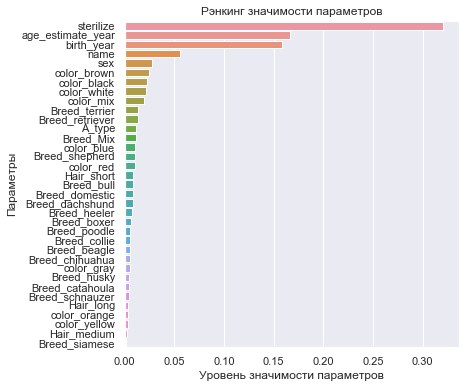

In [560]:
feature_report(Atype_+Breed_+Hair_+Color_+Sex_+Ster_+BirthY_+Age_+Name_, Adopt_)

Берем лучшие 3 признака: Возраст,  Наличие имени, Факт стерилизации  - ничего не теряем в информативности модели, взгляните:

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.79      0.75      0.77      8143
           1       0.71      0.75      0.73      6588

    accuracy                           0.75     14731
   macro avg       0.75      0.75      0.75     14731
weighted avg       0.75      0.75      0.75     14731

Точность модели составила (%) 75.1408594121241


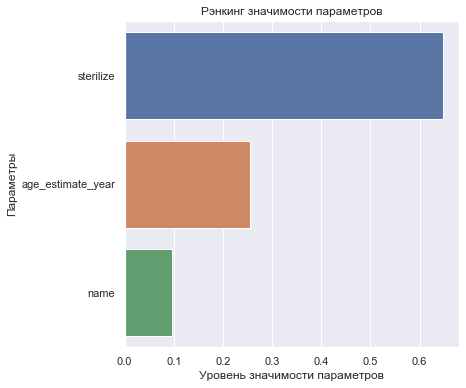

In [500]:
feature_report(Ster_+Age_+Name_, Adopt_)

Добавление породы в модель может ее улучшить (возможно), проверим:

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.79      0.76      0.78      8143
           1       0.72      0.76      0.74      6588

    accuracy                           0.76     14731
   macro avg       0.76      0.76      0.76     14731
weighted avg       0.76      0.76      0.76     14731

Точность модели составила (%) 75.85364197949902


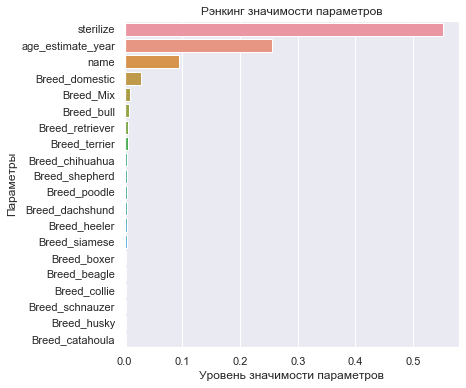

In [511]:
feature_report(Breed_+Ster_+Age_+Name_, Adopt_)

А если вместо породы в модель включить различение по виду животного и не углубляться в детали получится еще лучше:

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.81      0.75      0.78      8143
           1       0.72      0.78      0.75      6588

    accuracy                           0.76     14731
   macro avg       0.76      0.76      0.76     14731
weighted avg       0.77      0.76      0.76     14731

Точность модели составила (%) 76.22700427669541


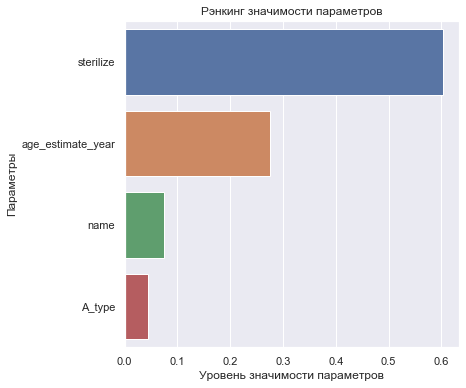

In [513]:
feature_report(Atype_+Ster_+Age_+Name_, Adopt_)


Outcome_type метка Transfer



C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.82      0.89      0.86     10173
           1       0.71      0.57      0.64      4558

    accuracy                           0.80     14731
   macro avg       0.77      0.73      0.75     14731
weighted avg       0.79      0.80      0.79     14731

Точность модели составила (%) 79.57368814065576


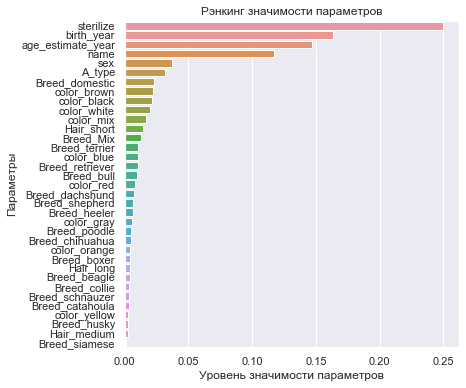

In [515]:
feature_report(Atype_+Breed_+Hair_+Color_+Sex_+Ster_+BirthY_+Age_+Name_, Trans_)
# Вероятность предсказания выше, состав и иерархия признаков примерно такая же

In [516]:
err_regress (Atype_+Breed_+Hair_+Color_+Sex_+Ster_+BirthY_+Age_+Name_, Trans_)

Weights: [[-0.053 -0.015 -0.025 -0.006 -0.027 -0.03  -0.015 -0.004 -0.108 -0.015
   0.015 -0.006 -0.062 -0.027 -0.011 -0.008 -0.028  0.001  0.001  0.072
   0.062  0.034  0.004  0.017 -0.003  0.005 -0.022  0.002 -0.022  0.01
  -0.024 -0.008 -0.383 -0.016 -0.015 -0.203]]
Bias: [33.607]
Error: 0.30553498627888964


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.81      0.94      0.87     10173
           1       0.79      0.51      0.62      4558

    accuracy                           0.81     14731
   macro avg       0.80      0.73      0.75     14731
weighted avg       0.81      0.81      0.79     14731

Точность модели составила (%) 80.82954314031635


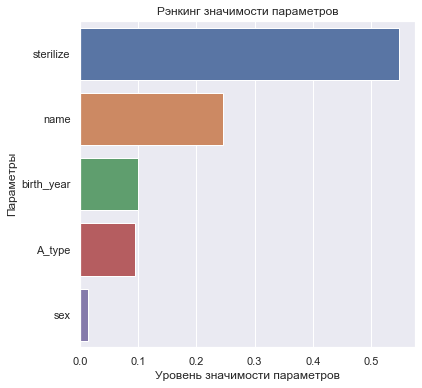

In [517]:
feature_report(Atype_+Sex_+Ster_+Age_+Name_, Trans_)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.83      0.93      0.88     10173
           1       0.79      0.56      0.66      4558

    accuracy                           0.82     14731
   macro avg       0.81      0.75      0.77     14731
weighted avg       0.82      0.82      0.81     14731

Точность модели составила (%) 81.8342271400448


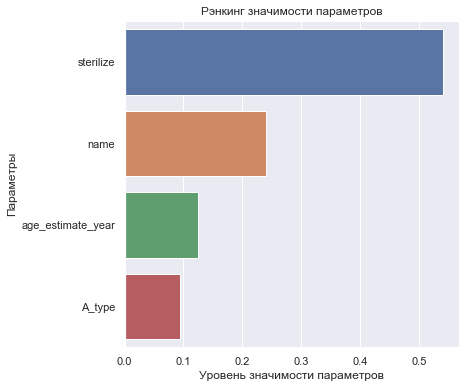

In [518]:
feature_report (Atype_+Ster_+Age_+Name_, Trans_)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.83      0.93      0.87     10173
           1       0.78      0.57      0.66      4558

    accuracy                           0.82     14731
   macro avg       0.80      0.75      0.77     14731
weighted avg       0.81      0.82      0.81     14731

Точность модели составила (%) 81.63057497793768


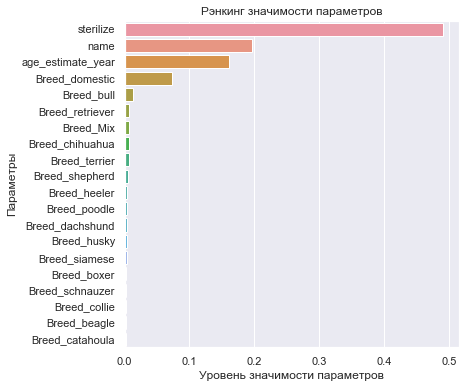

In [524]:
feature_report (Breed_+Ster_+Age_+Name_, Trans_)

А кстати: 

Классификационный тест Хи квадрат полностью подтверждает сделанные выше выводы:

In [540]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

array = data.values
X = array[:,0:35]
Y = array[:,35]

# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# summarize scores
np.set_printoptions(precision=3)

list_of_features = list(zip(data.columns, fit.scores_.round(2)))  
df = pd.DataFrame(list_of_features, columns = ['feature', 'rate'])  

df.sort_values(by = ['rate'], ascending = False).head(5)

,feature,rate
32,age_estimate_year,7836.42
31,sterilize,4881.01
34,name,855.42
2,Breed_bull,189.49
28,color_gray,103.19


интересно, а для котов так же все,  как и в  среднем по больнице?

In [561]:
array = data[data.A_type==0].values
X_c = array[:,0:35]
Y_c = array[:,35]

# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X_c, Y_c)

# summarize scores
np.set_printoptions(precision=3)

list_of_features = list(zip(data.columns, fit.scores_.round(2)))  
df = pd.DataFrame(list_of_features, columns = ['feature', 'rate'])  

df.sort_values(by = ['rate'], ascending = False).head(5)

,feature,rate
31,sterilize,4466.31
34,name,2803.62
32,age_estimate_year,937.87
28,color_gray,84.00
29,color_mix,9.82


почти ... но приоритеты другие

In [549]:
X = data.iloc[:,Atype_+Breed_+Hair_+Color_+Sex_+Ster_+BirthY_+Age_+Name_]
y = data.iloc[:,Adopt_]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

In [550]:
from sklearn.preprocessing import StandardScaler
stand_scaler = StandardScaler()
X_train_scaled = stand_scaler.fit_transform(X_train)
X_test_scaled = stand_scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

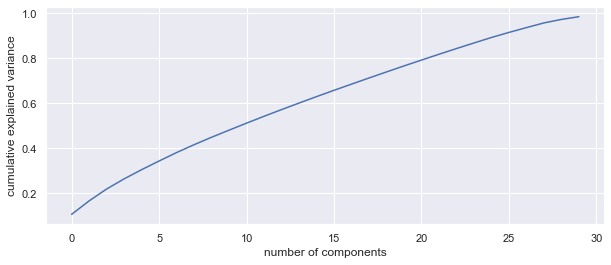

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.107225,0.107225
1,0.167069,0.059844
2,0.219818,0.052749
3,0.264911,0.045093
4,0.305702,0.040791
5,0.344380,0.038677
6,0.381803,0.037423
7,0.416786,0.034983
8,0.449848,0.033063
9,0.481412,0.031563


In [545]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=30)
pca_test.fit(X_train_scaled)
plt.figure(figsize=(10,4)) 
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))